In [1]:
import time

import numpy as np
from IPython.display import Image
from keras.callbacks import TensorBoard
from keras.layers import Dense
from keras.models import Sequential
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import plot_surface
from pyswarms.utils.plotters.formatters import Animator, Designer, Mesher
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import warnings
warnings.filterwarnings("ignore")

2023-05-28 17:28:58.354284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 17:28:58.477863: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-28 17:28:58.851418: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/TensorRT/lib:/usr/local/cuda-11.2/lib64:/usr/local/TensorRT/lib:
2023-05-28 17:28:58.851559: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load d

In [2]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.5, random_state=2)
n_features = X.shape[1]
n_classes = Y.shape[1]

In [3]:
def create_custom_model(input_dim, output_dim, nodes, n=1, name='model'):
    model = Sequential(name=name)
    for i in range(n):
        model.add(Dense(nodes, input_dim=input_dim, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model



In [4]:
n_layers = 1
model = create_custom_model(n_features, n_classes,
                            4, n_layers)
model.summary()

start_time = time.time()
print('Model name:', model.name)
history_callback = model.fit(X_train, Y_train,
                             batch_size=5,
                             epochs=400,
                             verbose=0,
                             validation_data=(X_test, Y_test)
                             )
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("--- %s seconds ---" % (time.time() - start_time))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 3)                 15        
                                                                 
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


2023-05-28 17:29:19.512279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-28 17:29:19.516705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-28 17:29:19.516924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-28 17:29:19.517342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model name: model


2023-05-28 17:29:20.713676: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3/3 [==============================] - 0s 1ms/step - loss: 0.0960 - accuracy: 0.9600
Test loss: 0.09600644558668137
Test accuracy: 0.9599999785423279
--- 13.446455717086792 seconds ---


In [5]:
def get_shape(model):
    weights_layer = model.get_weights()
    shapes = []
    for weights in weights_layer:
        shapes.append(weights.shape)
    return shapes
def set_shape(weights,shapes):
    new_weights = []
    index=0
    for shape in shapes:
        if(len(shape)>1):
            n_nodes = np.prod(shape)+index
        else:
            n_nodes=shape[0]+index
        tmp = np.array(weights[index:n_nodes]).reshape(shape)
        new_weights.append(tmp)
        index=n_nodes
    return new_weights

In [6]:
start_time = time.time()
def evaluate_nn(W, shape,X_train=X_train, Y_train=Y_train):
    results = []
    for weights in W:
        model.set_weights(set_shape(weights,shape))
        score = model.evaluate(X_train, Y_train, verbose=0)
        results.append(1-score[1])
    return results

shape = get_shape(model)
x_max = 1.0 * np.ones(35)
x_min = -1.0 * x_max
bounds = (x_min, x_max)
options = {'c1': 0.4, 'c2': 0.6, 'w': 0.4}
optimizer = GlobalBestPSO(n_particles=50, dimensions=35,
                          options=options, bounds=bounds)
cost, pos = optimizer.optimize(evaluate_nn, 20, X_train=X_train, Y_train=Y_train,shape=shape)
model.set_weights(set_shape(pos,shape))
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("--- %s seconds ---" % (time.time() - start_time))

2023-05-28 17:29:35,386 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.4, 'c2': 0.6, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=0.0133
2023-05-28 17:30:07,637 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.013333320617675781, best pos: [ 0.17027965  0.17696722 -0.07395054  0.31544984  0.17052408 -0.37810479
  0.24267479  0.16931148  0.65606942 -0.24207116 -0.66562722  0.02191478
  0.5870387   0.78966943 -0.4457816   0.0907434  -0.1808341   0.29282655
  0.61472003  0.90660508  0.16469465 -0.55057763  0.54702005 -0.22636745
  0.01125538  0.62431828  0.02128613 -0.26723577 -0.43527016  0.51223244
  0.76388399 -0.02073011  0.15949622  0.45878514  0.01787211]


3/3 [==============================] - 0s 1ms/step - loss: 0.7467 - accuracy: 0.9600
Test loss: 0.7467350363731384
Test accuracy: 0.9599999785423279
--- 32.29235529899597 seconds ---


2023-05-28 17:30:08,140 - matplotlib.animation - WARNING - MovieWriter pillowwritter unavailable; using Pillow instead.
2023-05-28 17:30:08,141 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


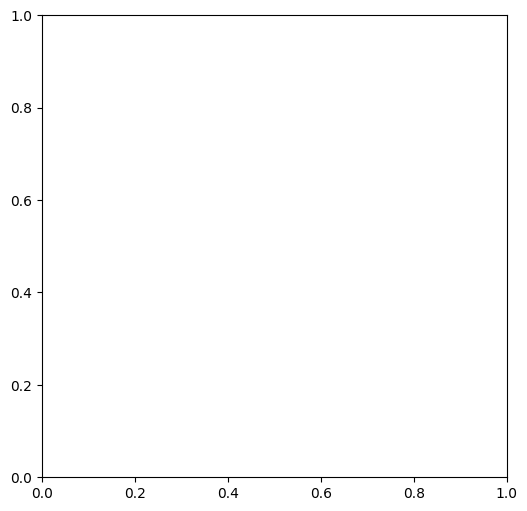

In [7]:
m = Mesher(func=fx.sphere)
pos_history = [pos[:, :2] for pos in optimizer.pos_history]
pos3d = m.compute_history_3d(pos_history)
# Assuming we already had an optimizer ready
my_animator = Animator(repeat=False)
my_designer = Designer(figsize=(6, 6))
animation = plot_surface(pos3d, animator=my_animator, designer=my_designer)
# %%
animation.save('pso.gif', writer='pillowwritter', fps=6, )
Image(url='pso.gif')

In [8]:

from sklearn.model_selection import KFold

In [9]:
X = iris["data"]
y = iris["target"]

enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inputs = X_scaled
targets = Y

num_folds = 5

kfold = KFold(n_splits=num_folds, shuffle=True)

fold_no = 1
accs_bp = []

x_max = 1.0 * np.ones(35)
x_min = -1.0 * x_max
bounds = (x_min, x_max)

for train, test in kfold.split(inputs, targets):
    model = create_custom_model(n_features, n_classes,
                                4, 1)
    shape = get_shape(model)
    history_callback = model.fit(inputs[train], targets[train],
                                batch_size=5,
                                epochs=400,
                                verbose=0,
                                )
    score = model.evaluate(inputs[test], targets[test])
    fold_no += 1
    accs_bp.append(score[1])

1/1 [==============================] - 0s 67ms/step - loss: 0.1448 - accuracy: 0.9333


2023-05-28 17:31:01,885 - tensorflow - WARNING - 5 out of the last 3010 calls to <function Model.make_test_function.<locals>.test_function at 0x7fee6622df70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 69ms/step - loss: 0.0451 - accuracy: 1.0000


2023-05-28 17:31:08,794 - tensorflow - WARNING - 6 out of the last 3011 calls to <function Model.make_test_function.<locals>.test_function at 0x7fee66257b80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 68ms/step - loss: 0.0970 - accuracy: 0.9667


In [10]:
accs_pso=[]
for train, test in kfold.split(inputs, targets):
    options = {'c1': 0.4, 'c2': 0.4, 'w': 0.6}
    optimizer = GlobalBestPSO(n_particles=25, dimensions=35,
                            options=options, bounds=bounds)
    cost, pos = optimizer.optimize(evaluate_nn, 20, X_train=inputs[train], Y_train=targets[train],shape=shape, verbose=0)
    model.set_weights(set_shape(pos,shape))
    score = model.evaluate(inputs[test], targets[test])
    accs_pso.append(score[1])

1/1 [==============================] - 0s 13ms/step - loss: 0.6576 - accuracy: 0.9333


In [11]:
accs_bp
print("Accuracy {:.2f} +/- {:.2f}".format(np.average(accs_bp),np.std(accs_bp)))

Accuracy 0.96 +/- 0.04


In [12]:
accs_pso
print("Accuracy {:.2f} +/- {:.2f}".format(np.average(accs_pso),np.std(accs_pso)))

Accuracy 0.90 +/- 0.08
